In [74]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from map_environment import MapEnvironment, Point2D, create_sample_map
from pathfinding import find_grid_path
from vehicle import Vehicle
from visibility import compute_path_visibility, compute_visibility_polygon
from visualization import (
    animate_vehicle,
    plot_all_visibility,
    plot_grid,
    plot_map,
    plot_path,
    plot_visibility,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1 -- Create the Map with Obstacles

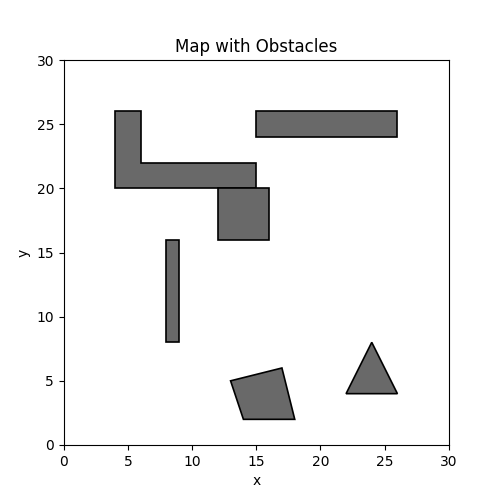

In [75]:
map_env: MapEnvironment = create_sample_map()

fig, ax = plt.subplots(figsize=(5, 5))
plot_map(ax, map_env)
plt.show()

## Step 2 -- Grid Overlay

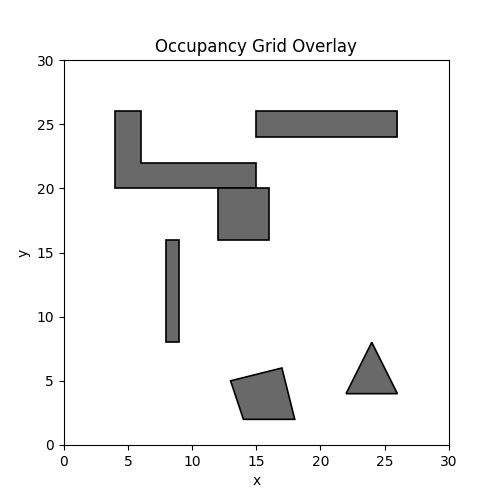

In [76]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_map(ax, map_env)
plot_grid(ax, map_env)
plt.show()

## Step 3 -- A* Pathfinding

Path found with 31 waypoints.


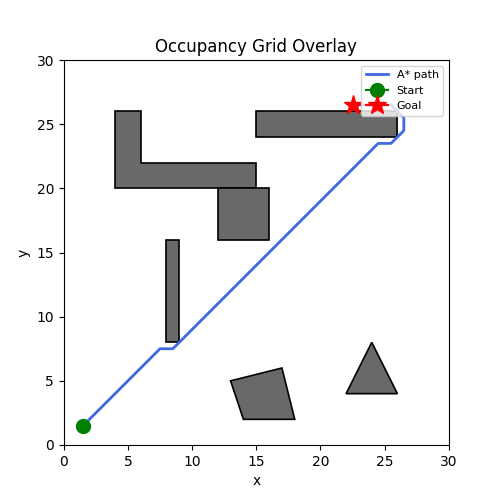

In [78]:
start: Point2D = Point2D(1.0, 1.0)
goal: Point2D = Point2D(22.0, 26.0)

path: list[Point2D] | None = find_grid_path(map_env, start, goal)

if path is None:
    print("No path found!")
else:
    print(f"Path found with {len(path)} waypoints.")

    fig, ax = plt.subplots(figsize=(5, 5))
    plot_map(ax, map_env)
    plot_grid(ax, map_env)
    plot_path(ax, path)
    plt.show()

## Step 4 -- Visibility at Key Waypoints

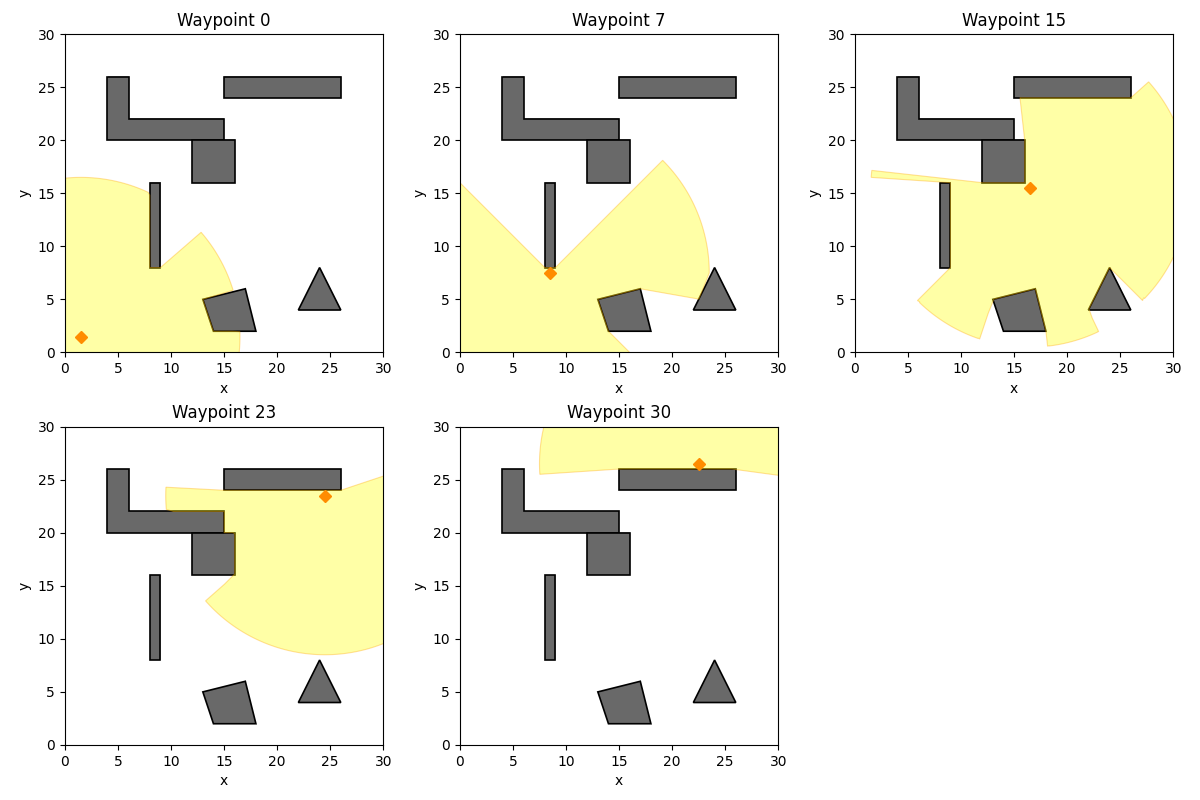

In [79]:
assert path is not None, "Path must exist for visibility computation."

# Pick a few representative waypoints: start, 1/4, 1/2, 3/4, end
indices: list[int] = [
    0,
    len(path) // 4,
    len(path) // 2,
    3 * len(path) // 4,
    len(path) - 1,
]
max_radius: float = 15.0

n_plots: int = len(indices)
n_cols: int = 3
n_rows: int = (n_plots + n_cols - 1) // n_cols  # ceil division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
flat_axes = axes.flatten()

for i, idx in enumerate(indices):
    ax = flat_axes[i]
    observer: Point2D = path[idx]
    vis_poly = compute_visibility_polygon(observer, map_env.obstacles, max_radius)

    plot_map(ax, map_env)
    plot_grid(ax, map_env)
    plot_visibility(ax, observer, vis_poly)
    ax.set_title(f"Waypoint {idx}")

# Hide any unused subplot slots
for j in range(n_plots, len(flat_axes)):
    flat_axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## Step 5 -- Combined Visibility along the Entire Path

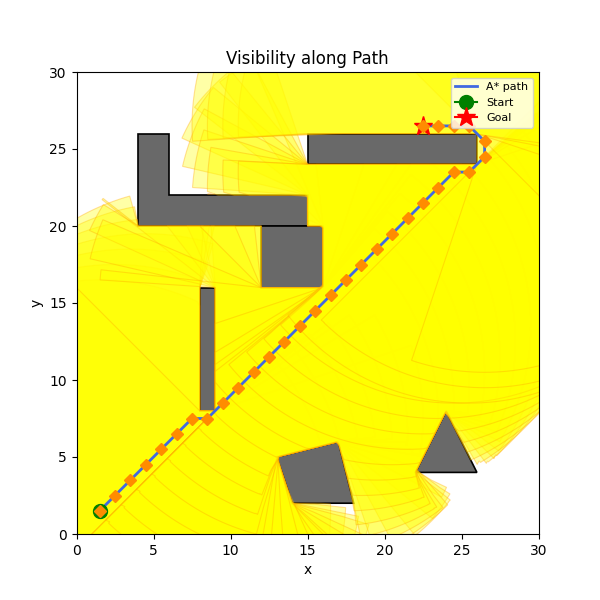

In [80]:
visibility_polygons: list = compute_path_visibility(
    path, map_env.obstacles, max_radius
)

fig, ax = plt.subplots(figsize=(6, 6))
plot_map(ax, map_env)
plot_grid(ax, map_env)
plot_all_visibility(ax, path, visibility_polygons)
plot_path(ax, path)
plt.show()

## Step 6 -- Animated Vehicle Traversal with Path Prediction

A `Vehicle` moves along the A* path at a specified speed.  The animation shows:
- **Orange dot / line** -- current vehicle position and heading.
- **Green dashed line / dots** -- predicted positions over the next few seconds.
- **Yellow region** -- real-time visibility polygon.

Path length : 39.9 units
Vehicle speed: 2.0 units/s
Travel time  : 20.0 s


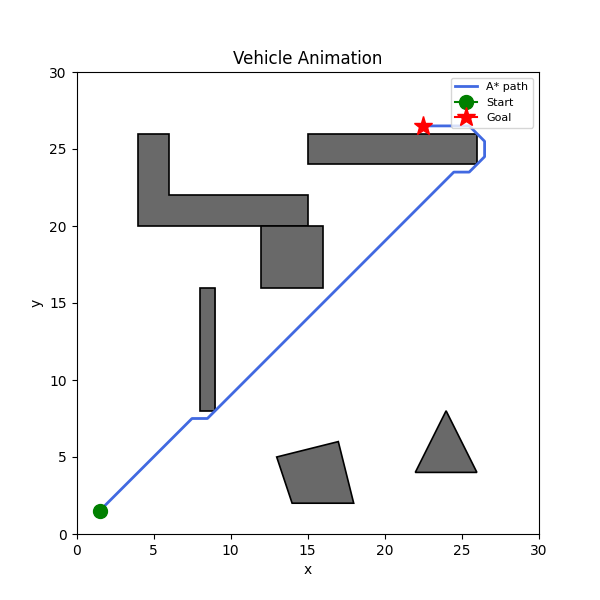

In [81]:
assert path is not None, "Path must exist for animation."

# Create a vehicle that moves at 2 units/second.
vehicle: Vehicle = Vehicle(path, speed=2.0)
print(f"Path length : {vehicle.total_length:.1f} units")
print(f"Vehicle speed: {vehicle.speed} units/s")
print(f"Travel time  : {vehicle.total_time:.1f} s")

fig, ax = plt.subplots(figsize=(6, 6))

anim = animate_vehicle(
    fig,
    ax,
    map_env,
    vehicle,
    max_vis_radius=max_radius,
    prediction_horizon=3.0,  # predict 3 seconds into the future
    prediction_samples=8,    # 8 sample dots along the prediction
    dt=0.15,                 # simulation timestep per frame
    interval_ms=60,          # milliseconds between frames
)

plt.show()

## Step 7 -- Observer Vehicle: Greedy Lookahead Planner

Planning observer path (Greedy Lookahead) ...
  Observer trajectory: 135 waypoints
  LOS maintained: 128/135 (94.8%)


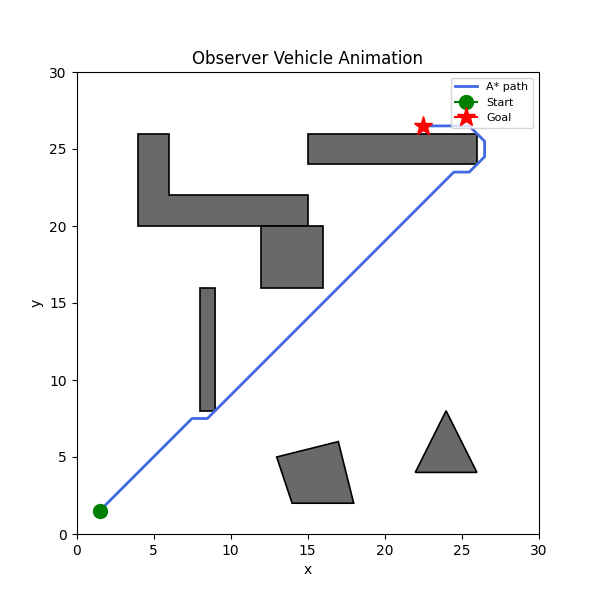

In [82]:
from observer_planner import (
    GreedyLookaheadPlanner,
    has_line_of_sight,
    plan_observer_path,
)
from visualization import animate_two_vehicles
from visibility import _collect_segments

strategy_greedy = GreedyLookaheadPlanner(num_candidates=36, horizon_steps=10, preferred_distance=5.0)
observer_start: Point2D = Point2D(3.0, 3.0)

print("Planning observer path (Greedy Lookahead) ...")
observer_positions_greedy = plan_observer_path(
    strategy=strategy_greedy,
    target_vehicle=vehicle,
    obstacles=map_env.obstacles,
    start_pos=observer_start,
    max_speed=3.0,
    dt=0.15,
    max_vis_radius=max_radius,
)
print(f"  Observer trajectory: {len(observer_positions_greedy)} waypoints")

# Compute LOS maintenance percentage
_segments = _collect_segments(map_env.obstacles)
_los_count = sum(
    1
    for k, obs_pos in enumerate(observer_positions_greedy)
    if has_line_of_sight(obs_pos, vehicle.position_at(k * 0.15), _segments)
)
_los_pct = 100.0 * _los_count / len(observer_positions_greedy)
print(f"  LOS maintained: {_los_count}/{len(observer_positions_greedy)} ({_los_pct:.1f}%)")

fig, ax = plt.subplots(figsize=(6, 6))
anim_greedy = animate_two_vehicles(
    fig, ax, map_env, vehicle, observer_positions_greedy,
    max_vis_radius=max_radius,
    prediction_horizon=3.0,
    prediction_samples=8,
    dt=0.15,
    interval_ms=60,
)
plt.show()

## Step 8 -- Observer Vehicle: MPPI Planner

Planning observer path (MPPI) ...
  Observer trajectory: 135 waypoints
  LOS maintained: 121/135 (89.6%)


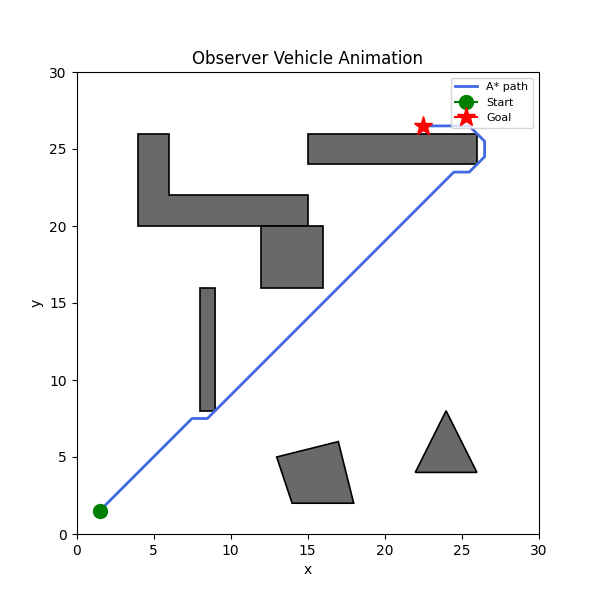

In [83]:
from observer_planner import MPPIPlanner

strategy_mppi = MPPIPlanner(K=128, horizon_steps=10, sigma=1.5, lambda_=0.1, preferred_distance=5.0)
observer_start_mppi: Point2D = Point2D(3.0, 3.0)

print("Planning observer path (MPPI) ...")
observer_positions_mppi = plan_observer_path(
    strategy=strategy_mppi,
    target_vehicle=vehicle,
    obstacles=map_env.obstacles,
    start_pos=observer_start_mppi,
    max_speed=3.0,
    dt=0.15,
    max_vis_radius=max_radius,
)
print(f"  Observer trajectory: {len(observer_positions_mppi)} waypoints")

# Compute LOS maintenance percentage
_los_count_mppi = sum(
    1
    for k, obs_pos in enumerate(observer_positions_mppi)
    if has_line_of_sight(obs_pos, vehicle.position_at(k * 0.15), _segments)
)
_los_pct_mppi = 100.0 * _los_count_mppi / len(observer_positions_mppi)
print(f"  LOS maintained: {_los_count_mppi}/{len(observer_positions_mppi)} ({_los_pct_mppi:.1f}%)")

fig, ax = plt.subplots(figsize=(6, 6))
anim_mppi = animate_two_vehicles(
    fig, ax, map_env, vehicle, observer_positions_mppi,
    max_vis_radius=max_radius,
    prediction_horizon=3.0,
    prediction_samples=8,
    dt=0.15,
    interval_ms=60,
)
plt.show()

## Step 9 -- Observer Vehicle: Scipy MPC Planner

Planning observer path (Scipy MPC) ...
  Observer trajectory: 135 waypoints
  LOS maintained: 120/135 (88.9%)


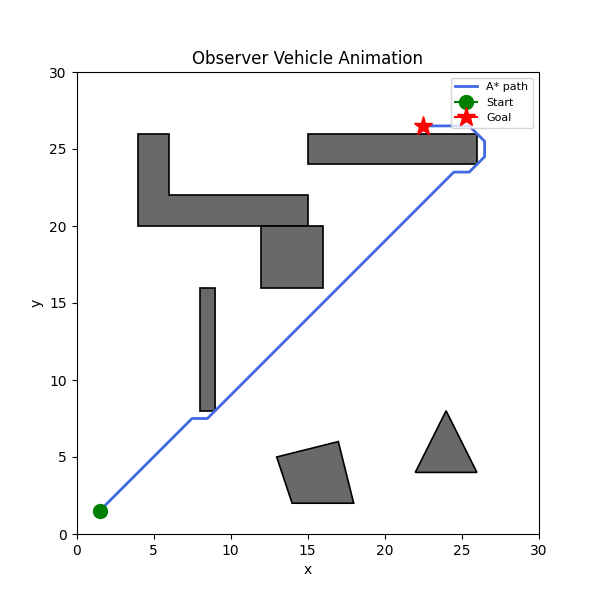

In [84]:
from observer_planner import ScipyMPCPlanner

strategy_scipy = ScipyMPCPlanner(
    horizon_steps=10,
    w_los=10.0,
    w_dist=1.0,
    w_smooth=0.5,
    w_speed=100.0,
    preferred_distance=5.0,
)
observer_start_scipy: Point2D = Point2D(3.0, 3.0)

print("Planning observer path (Scipy MPC) ...")
observer_positions_scipy = plan_observer_path(
    strategy=strategy_scipy,
    target_vehicle=vehicle,
    obstacles=map_env.obstacles,
    start_pos=observer_start_scipy,
    max_speed=3.0,
    dt=0.15,
    max_vis_radius=max_radius,
)
print(f"  Observer trajectory: {len(observer_positions_scipy)} waypoints")

# Compute LOS maintenance percentage
_los_count_scipy = sum(
    1
    for k, obs_pos in enumerate(observer_positions_scipy)
    if has_line_of_sight(obs_pos, vehicle.position_at(k * 0.15), _segments)
)
_los_pct_scipy = 100.0 * _los_count_scipy / len(observer_positions_scipy)
print(f"  LOS maintained: {_los_count_scipy}/{len(observer_positions_scipy)} ({_los_pct_scipy:.1f}%)")

fig, ax = plt.subplots(figsize=(6, 6))
anim_scipy = animate_two_vehicles(
    fig, ax, map_env, vehicle, observer_positions_scipy,
    max_vis_radius=max_radius,
    prediction_horizon=3.0,
    prediction_samples=8,
    dt=0.15,
    interval_ms=60,
)
plt.show()